In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import world_bank_data as wb

## Analysis of the death rates in Covid crisis versus previous years in the Netherlands

Import the data of the weakly deaths in NL and make plots

Data source: https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70895ned/table?fromstatweb

In [55]:
deaths_NL = pd.read_csv("data/overledenen_NL_wekelijks.csv", sep = ';')

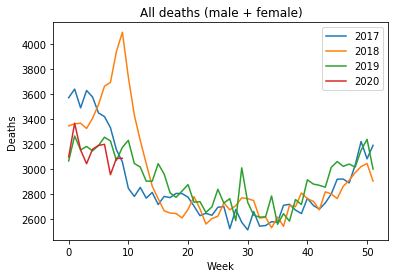

In [102]:
total_deaths = deaths_NL['Totaal leeftijd man en vrouw']
plt.plot(np.arange(0,52),total_deaths[0:52], label = '2017')
plt.plot(np.arange(0,52),total_deaths[52:104], label = '2018')
plt.plot(np.arange(0,52),total_deaths[104:156], label = '2019')
plt.plot(np.arange(0,total_deaths[156:-1].shape[0]),deaths_NL['Totaal leeftijd man en vrouw'][156:-1], label = '2020')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Deaths')
plt.title('All deaths (male + female)')
plt.show()

Not enough data yet to see the effects of Covid. We do observe a significant peak around the 10th week of 2018 as well (there was a flu outbreak in the Netherlands). Will Covid peak be smaller, larger or similar? We will keep updating the data. 

To keep in mind: death rates might be reported with a delay or underreported.

Differences between Covid and other similar viruses: Covid patients spend more time on the ventilator; incubation period for Covid is longer, and the infection rate is higher.

## Analysis of Covid around the world

We are interested in finding some correlations and explanations for the spread of Covid.

We will use data from: 

- Covid-19 cases: https://github.com/datasets/covid-19/tree/master/data

- World population: https://github.com/datasets/population/blob/master/data/population.csv

- Air quality: https://github.com/duncangeere/dataviz-airpollution/blob/master/data.csv (alternative with per city: https://github.com/duncangeere/dataviz-airpollution/blob/master/airpollution.csv; alternative with pollution index https://www.numbeo.com/pollution/rankings.jsp) 

- Population of 65 and up as a % of total population: https://data.worldbank.org/indicator/SP.POP.65UP.TO.ZS

- Average temperatures: https://github.com/klistwan/monthly-temperatures/blob/master/datasets/average_monthly_highs.csv (would be better to update this to averages per country over Feb 2020, but haven't found that yet)

Notes and questions:

- In all the different models used to predict the amount of infected and the amount of deaths, what numbers are these based on? If our testing strategies are only to test people with symptoms these numbers must be biased. What I would like to understand here is whether it is possible to assume that all over the world we have a whole lot more of infected people already. These people just do not show any symptoms. This would mean that we have much lower death rates than currently estimated. 

- Can we assume that Italy does not have more contacts (through flights etc.) with China (where virus originated) than any other country? If that is indeed not the case we need to look for other explanations as to why Italy was hit so bad. If it is the case and Italy was by chance the first country which the virus reached, then a small amount of infected people (assuming that the virus arrived only with a small amount of people) can infect a very large amount of people. This would imply that a lockdown only works to 'shift' the peak since an arbitrarily small amount of people with the virus can re-spike the infection. 

- If virus goes unnoticed (asymptomatic cases) until it reaches a certain population type (e.g. the elderly, people with previous health conditions, people with weaker immune systems, people with worse lung conditions) we would need to see correlations between the amount of illnesses in a country and the countries' demographic data, weather conditions, air pollution, etc. If the surge in severely ill can be explained by these variables it could mean that all over the world the amount of infected and asymptomatic is a whole lot higher.

In [51]:
# Load covid-19 data 
url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv"
countries_agg = pd.read_csv(url, error_bad_lines=False)
countries_agg = countries_agg.applymap(lambda s:s.lower() if type(s) == str else s)
countries_agg.to_csv('data/countries-aggregated.csv', sep=';')
# Load world population data (last year is 2016)
url = "https://raw.githubusercontent.com/datasets/population/master/data/population.csv"
world_pop = pd.read_csv(url, error_bad_lines=False)
world_pop = world_pop.applymap(lambda s:s.lower() if type(s) == str else s)
world_pop = world_pop[world_pop['Year']==2016]
world_pop.to_csv('data/world_pop.csv', sep=';')
world_pop.loc[world_pop['Country Name']=="korea, dem. people’s rep.", 'Country Name']="korea, south"
world_pop.loc[world_pop['Country Name']=="united states", 'Country Name']="us"
# Air quality per country (year 2014)
url = "https://raw.githubusercontent.com/duncangeere/dataviz-airpollution/master/data.csv"
air_quality = pd.read_csv(url, error_bad_lines=False, header=1)
air_quality = air_quality.applymap(lambda s:s.lower() if type(s) == str else s)
air_quality['Country'][air_quality['Country']=='united kingdom of great britain and northern ireland']='united kingdom'
air_quality['Country'][air_quality['Country']=="democratic people's republic of korea"]="korea, south"
air_quality['Country'][air_quality['Country']=="united states of america"]="us"
air_quality.to_csv('data/air_quality.csv', sep=';')
# Population of 65 and up (year 2018)
pop_65 = wb.get_series('SP.POP.65UP.TO.ZS', date='2018',simplify_index=True)
pop_65 = pd.DataFrame(list(zip(pop_65.index.values, pop_65.values)), columns = ['Country', 'Value']) 
pop_65 = pop_65.applymap(lambda s:s.lower() if type(s) == str else s)
pop_65.loc[pop_65['Country']=="korea, dem. people’s rep.",'Country']="korea, south"
pop_65.loc[pop_65['Country']=="united states",'Country']="us"
pop_65.to_csv('data/population_65up.csv', sep=';')
# Average temperature data
url = "https://raw.githubusercontent.com/klistwan/monthly-temperatures/master/datasets/average_monthly_highs.csv"
temps = pd.read_csv(url, error_bad_lines=False)
temps = temps.applymap(lambda s:s.lower() if type(s) == str else s)
# Modify the temperature data such that is is averaged per country 
temps = temps.groupby('country').mean().reset_index()
temps.loc[temps['country']=="south korea", 'country']="korea, south"
temps.loc[temps['country']=="united states of america", 'country']="us"
temps.to_csv('data/temperatures.csv', sep=';')

Let's plot Italy compared to the Netherlands and the UK (dataset starts on 22nd of January)

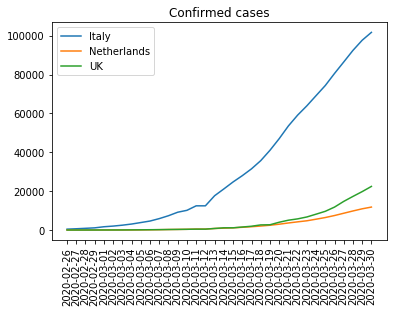

In [11]:
IT_agg = countries_agg[countries_agg['Country'] == 'italy']
NL_agg = countries_agg[countries_agg['Country'] == 'netherlands']
UK_agg = countries_agg[countries_agg['Country'] == 'united kingdom']
n_p = 35
plt.plot(IT_agg['Date'][n_p:], IT_agg['Confirmed'][n_p:], label = 'Italy')
plt.plot(NL_agg['Date'][n_p:], NL_agg['Confirmed'][n_p:], label = 'Netherlands')
plt.plot(UK_agg['Date'][n_p:], UK_agg['Confirmed'][n_p:], label = 'UK')
plt.title('Confirmed cases')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Let us extract the variables that we will use for the correlation analysis

In [125]:
countries = ['australia', 'belgium', 'canada', 'china', 'croatia', 'denmark', 'finland', 'france', 
             'germany', 'hungary', 'india', 'italy', 'japan', 'korea, south', 'netherlands', 'poland',
             'spain', 'sweden', 'us', 'united kingdom']
pop_65_s = pop_65[pop_65['Country'].isin(countries).values]
pop_65_s = pop_65.set_index('Country')
world_pop_s = world_pop[world_pop['Country Name'].isin(countries).values][['Country Name', 'Value']]
world_pop_s = world_pop_s.set_index('Country Name')
air_q_s = air_quality[air_quality['Country'].isin(countries).values][['Country', '2014']]
air_q_s = air_q_s.set_index('Country')
temps_s = temps[temps['country'].isin(countries).values][['country', 'feb']]
temps_s = temps_s.set_index('country')
cases_s = countries_agg[countries_agg['Country'].isin(countries).values]
cases_ld_s_v = cases_s[cases_s['Date']=='2020-03-30'][['Country', 'Confirmed']]
cases_ld_s_v = cases_ld_s_v.set_index('Country')
# Make a new dataframe with info we are interested in
total = cases_ld_s_v.merge(temps_s, left_index=True, right_index=True)
total = total.merge(air_q_s, left_index=True, right_index=True)
total = total.merge(world_pop_s, left_index=True, right_index=True)
total = total.merge(pop_65_s, left_index=True, right_index=True)
total.columns = ['Confirmed', 'Temp feb', 'Air', 'Population', '65over']
total['Confirmed'] = total['Confirmed'].values/total['Population'].values*1000000
total = total.drop(['Population'], axis = 1)
print(total)

                  Confirmed   Temp feb   Air     65over
australia        180.750664  27.695833   5.8  15.656475
belgium         1048.540120   4.956000  16.0  18.788744
canada           203.877896  -2.053125   7.3  17.232007
china             59.621445   5.497468  61.8  10.920884
croatia          189.421186   7.885185  20.5  20.445433
denmark          480.709000   1.954545  10.5  19.812953
finland          246.037558  -4.380000   7.1  21.720788
france           675.226118   9.644000  12.7  20.034625
germany          809.082775   3.400000  14.5  21.461962
hungary           45.528816   2.908333  22.9  19.157725
india              0.944742  27.086538  73.6   6.179956
italy           1678.845041  10.262963  18.6  22.751680
japan             14.693548   7.847368  13.0  27.576370
korea, south     380.824814   4.982692  31.6   9.334520
netherlands      694.365771   4.452632  14.9  19.196193
poland            54.153029   3.264706  25.8  17.517817
spain           1893.809268  15.523077  10.0  19

Let's make some plots

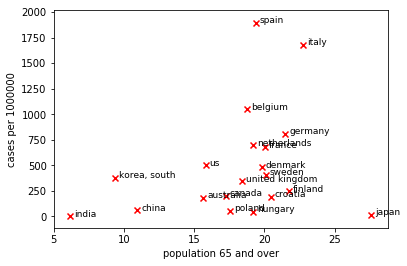

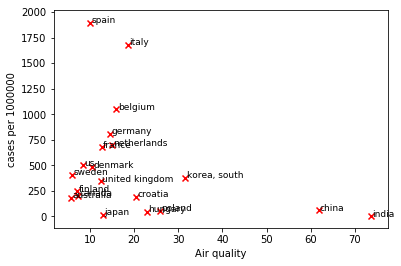

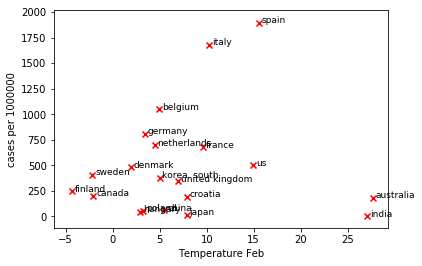

In [151]:
# Plot against population of 65 and over
for i,name in enumerate(total.index.values):
    x = total['65over'].values[i]
    y = total['Confirmed'].values[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, name, fontsize=9)
plt.xlabel('population 65 and over')
plt.ylabel('cases per 1000000')
plt.show()

# Plot against air quality
for i,name in enumerate(total.index.values):
    x = float(total['Air'].values[i])
    y = total['Confirmed'].values[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, name, fontsize=9)
plt.xlabel('Air quality')
plt.ylabel('cases per 1000000')
plt.show()

# Plot against temperature
for i,name in enumerate(total.index.values):
    x = total['Temp feb'].values[i]
    y = total['Confirmed'].values[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, name, fontsize=9)
plt.xlabel('Temperature Feb')
plt.ylabel('cases per 1000000')
plt.show()

# A modelling example

Can we replicate the observed amount of confirmed cases by simulating a SIR model with per population
- rates of contagion between populations (i.e. this will represent the travel between countries),
- multiple age groups with various probabilities of becoming symptomatic, 
- general health indicator for whole population (representing air quality and more general lifestyle quality). 

Assuming fixed 
- contagion rate, 
- amount of encounters per person, 
- 